In [61]:
# Initial Imports:

import pandas as pd
from pathlib import Path
import pandas_datareader.data as reader
import datetime as dt
import statsmodels.api as sm
import getFamaFrenchFactors as gff

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# For visualizations:
import seaborn as sns

# PART I: DATA CAPTURE AND ORGANIZATION

In [62]:
# Set start and end times and establish BTC as our asset of investigation

end = dt.date(2022, 3, 31)
start = dt.date(2022, 1, 1)
ticker = ["BTC-USD"]

In [63]:
# Get BTC closing prices

btc_dreturns = reader.get_data_yahoo(ticker, start, end)["Close"]
display(btc_dreturns.head())
btc_dreturns.tail()

Symbols,BTC-USD
Date,
2022-01-01,47686.812500
2022-01-02,47345.218750
2022-01-03,46458.117188
2022-01-04,45897.574219
2022-01-05,43569.003906


Symbols,BTC-USD
Date,
2022-03-28,47128.003906
2022-03-29,47465.730469
2022-03-30,47062.664062
2022-03-31,45538.675781
2022-04-01,46281.644531


In [64]:
# Get daily returns of BTC

btc_dreturns = btc_dreturns.pct_change().dropna() #convert to daily returns and drop NaN values
display(btc_dreturns.head())
btc_dreturns.tail()

Symbols,BTC-USD
Date,
2022-01-02,-0.007163
2022-01-03,-0.018737
2022-01-04,-0.012066
2022-01-05,-0.050734
2022-01-06,-0.009366


Symbols,BTC-USD
Date,
2022-03-28,0.006568
2022-03-29,0.007166
2022-03-30,-0.008492
2022-03-31,-0.032382
2022-04-01,0.016315


In [65]:
# Get daily factor data  

ff3_daily = reader.DataReader("F-F_Research_Data_Factors_daily", "famafrench", start, end)[0]  
ff3_daily.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2022-01-03,0.73,0.32,0.79,0.0
2022-01-04,-0.29,-0.81,3.62,0.0
2022-01-05,-2.28,-1.46,2.60,0.0
2022-01-06,0.00,0.21,1.75,0.0
2022-01-07,-0.48,-1.32,2.02,0.0


In [66]:
# Divide select columns by 100 (because inputted Mkt-RF, SMB, and HML columns are in percentages while RF column is not).

ff3_daily[["Mkt-RF", "SMB", "HML"]] = ff3_daily[["Mkt-RF", "SMB", "HML"]]/100 
ff3_daily.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2022-01-03,0.0073,0.0032,0.0079,0.0
2022-01-04,-0.0029,-0.0081,0.0362,0.0
2022-01-05,-0.0228,-0.0146,0.0260,0.0
2022-01-06,0.0000,0.0021,0.0175,0.0
2022-01-07,-0.0048,-0.0132,0.0202,0.0


In [67]:
# Read in Momentum factor data from CSV included in Resources folder of this repo.
# Note: as per this notebook, using Momentum as a factor can be turned on and off with hashes in applicable cells.
# This notebook is set up to use it or not use it, depending on user preference.
# Across a number of time periods, we have not found it to be a significant factor with BTC.

momentum_factor = pd.read_csv(
    Path("./Resources/F-F_Momentum_Factor_daily.csv"),
    header=None
)

momentum_factor

,0,1
0,19261103,0.56
1,19261104,-0.50
2,19261105,1.17
3,19261106,-0.03
4,19261108,-0.01
...,...,...
25106,20220329,-1.98
25107,20220330,1.03
25108,20220331,0.40
25109,NaN,NaN


In [68]:
# Asssign column names

momentum_factor.columns = ["Date", "Mom"]
momentum_factor.columns

Index(['Date', 'Mom'], dtype='object')

In [69]:
# Choose select dates 

momentum_factor = momentum_factor.loc[
    (momentum_factor["Date"] >= "20220101")
   & (momentum_factor["Date"] <= "20220331")
]

In [70]:
display(momentum_factor.head())
momentum_factor.tail()

,Date,Mom
25047,20220103,-1.05
25048,20220104,0.40
25049,20220105,-0.71
25050,20220106,0.71
25051,20220107,-0.62


,Date,Mom
25104,20220325,1.11
25105,20220328,-0.45
25106,20220329,-1.98
25107,20220330,1.03
25108,20220331,0.40


In [71]:
# Set index

momentum_factor.set_index("Date")

,Mom
Date,
20220103,-1.05
20220104,0.40
20220105,-0.71
20220106,0.71
20220107,-0.62
...,...
20220325,1.11
20220328,-0.45
20220329,-1.98


In [72]:
# Drop NaNs

momentum_factor = momentum_factor.dropna()
momentum_factor.shape

(62, 2)

In [73]:
# Divide by 100 (because inputted Mom column is in percentages).

momentum_factor["Mom"] = momentum_factor["Mom"]/100  
momentum_factor.head()

,Date,Mom
25047,20220103,-0.0105
25048,20220104,0.0040
25049,20220105,-0.0071
25050,20220106,0.0071
25051,20220107,-0.0062


In [74]:
# Set index to the index of ff3_daily dataframe.

momentum_factor.index = ff3_daily.index

In [75]:
# Drop extra column

momentum_factor.drop(columns="Date", inplace=True)
momentum_factor

,Mom
Date,
2022-01-03,-0.0105
2022-01-04,0.0040
2022-01-05,-0.0071
2022-01-06,0.0071
2022-01-07,-0.0062
...,...
2022-03-25,0.0111
2022-03-28,-0.0045
2022-03-29,-0.0198


In [76]:
# Merging FF3 daily facotr data with BTC daily return data into one dataframe

regress_data = ff3_daily.merge(btc_dreturns, on="Date")  
display(regress_data.head())
regress_data.tail()

,Mkt-RF,SMB,HML,RF,BTC-USD
Date,,,,,
2022-01-03,0.0073,0.0032,0.0079,0.0,-0.018737
2022-01-04,-0.0029,-0.0081,0.0362,0.0,-0.012066
2022-01-05,-0.0228,-0.0146,0.0260,0.0,-0.050734
2022-01-06,0.0000,0.0021,0.0175,0.0,-0.009366
2022-01-07,-0.0048,-0.0132,0.0202,0.0,-0.037141


,Mkt-RF,SMB,HML,RF,BTC-USD
Date,,,,,
2022-03-25,0.0027,-0.0059,0.0217,0.0,0.008821
2022-03-28,0.0073,-0.0055,-0.0169,0.0,0.006568
2022-03-29,0.0145,0.0154,-0.0192,0.0,0.007166
2022-03-30,-0.0083,-0.0128,0.0039,0.0,-0.008492
2022-03-31,-0.0155,0.0071,-0.0044,0.0,-0.032382


In [77]:
# Merging combined FF3 daily factor and BTC daily returns data with Momentum daily factor data

#regress_data = data.merge(momentum_factor, on="Date")  
#regress_data = regress_data[["Mkt-RF", "SMB", "HML", "Mom", "RF", "BTC-USD"]] #ordering columns
#display(regress_data.head())
#regress_data.tail()

In [78]:
# Subtracting risk-free return rate from BTC's daily returns and creating a new column to store the result

regress_data["BTC-RF"] = regress_data["BTC-USD"] - regress_data["RF"]
regress_data.head()

,Mkt-RF,SMB,HML,RF,BTC-USD,BTC-RF
Date,,,,,,
2022-01-03,0.0073,0.0032,0.0079,0.0,-0.018737,-0.018737
2022-01-04,-0.0029,-0.0081,0.0362,0.0,-0.012066,-0.012066
2022-01-05,-0.0228,-0.0146,0.0260,0.0,-0.050734,-0.050734
2022-01-06,0.0000,0.0021,0.0175,0.0,-0.009366,-0.009366
2022-01-07,-0.0048,-0.0132,0.0202,0.0,-0.037141,-0.037141


<AxesSubplot:xlabel='Mkt-RF', ylabel='BTC-RF'>

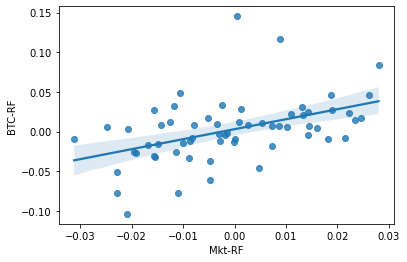

In [79]:
# Checking relationships between two variables graphically using seaborn regplot. Scatter plot shows excess returns on the 
# market versus excess returns on BTC.

sns.regplot(x="Mkt-RF", y="BTC-RF", data=regress_data) 

In [80]:
X = regress_data[["Mkt-RF", "SMB", "HML"]]  #the independent variables     
# X = regress_data[["Mkt-RF", "SMB", "HML", "Mom"]] #the independent variables four 4 factors
y = regress_data["BTC-RF"]  #the dependent variable

X1 = sm.add_constant(X) #defining the constant
model = sm.OLS(y, X1)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BTC-RF   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     5.762
Date:                Thu, 12 May 2022   Prob (F-statistic):            0.00161
Time:                        11:03:46   Log-Likelihood:                 120.23
No. Observations:                  62   AIC:                            -232.5
Df Residuals:                      58   BIC:                            -224.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.005      0.813      0.419      -0.006       0.013
Mkt-RF         0.9763      0.417      2.343      0.023       0.142       1.811
SMB            0.2639      0.679      0.389      0.699      -1.095       1.622
HML           -0.3382      0.433     -0.780      0.438      -1.206       0.529
==============================================================================
Omnibus:                       21.436   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.292
Skew:                           1.039   Prob(JB):                     8.87e-11
Kurtosis:                       6.688   Cond. No.                         155.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
#Note: The Prob (F-statistic) depicts probability of the null hypothesis being true, and can be thought of as the p-value for the 
#regression as a whole. Our F-statistic of effectively 0 implies that overall the regressions were significant.

#Last thing are the coefficients and the p-values for the X variables. The coefficients tell you the size of the effect that 
#the variable is having on the dependent variable when all other independent variables are held constant. Here, only the Mk-RF
#coefficient has a statistically significant p-value; the others are not statistically significant.

In [82]:
# Saving the coefficients, which tell us how much exposure BTC has to the market, size, value, and momentum. 
# Note on Fama French Factors: There is some systematic risk due to size, value (book equity to market equity), and momementum of 
# stocks. Stock risks are multidimensional! 

intercept, beta_m, beta_s, beta_v = results.params  
#intercept, beta_m, beta_s, beta_v, beta_mom = results.params   #for 4 factors
print(beta_m, beta_s, beta_v)
# print(beta_m, beta_s, beta_v, beta_mom)   #for 4 factors

0.9763438115749374 0.26391634587601676 -0.33819278836274547


In [83]:
# Getting average risk free rate

risk_free = regress_data["RF"].mean()
risk_free

0.0

In [84]:
# Calculating expected excess return of the market (the market risk premium). Note, all is based on daily returns! So as calculated here, 
# the average daily return of the S&P500 (in excess of risk-free rate) during this period is .0818%.
# Calculating expected excess return due to size (the size risk premium).
# Calculating expected excess return due to value (the value risk premium).
# Calculating expected excess return due to momentum (the momentum risk premium).

market_premium = regress_data["Mkt-RF"].mean()
size_premium = regress_data["SMB"].mean()
value_premium = regress_data["HML"].mean()
#momentum_premium = regress_data["Mom"].mean()  #use for 4 factors

print(market_premium, size_premium, value_premium)  #monthly premiums, shows how market, size, value, momentum yield premiums
#print(market_premium, size_premium, value_premium, momentum_premium) #use for 4 factors

-0.0008177419354838711 -0.0008387096774193552 0.0022370967741935496


In [85]:
#Compute expected return of BTC 

btc_exp_return = intercept + risk_free + (beta_m * market_premium) + (beta_s * size_premium) + (beta_v * value_premium) 
#btc_exp_return = risk_free + (beta_m * market_premium) + (beta_s * size_premium) + (beta_v * value_premium) + (beta_mom * momentum_premium) #use for 4 factors

btc_exp_yr_return = btc_exp_return * 252

print(f"Using the Fama French Four Factor model, the expected daily return of Bitcoin is: %{btc_exp_return*100}.")
print(f"Using the Fama French Four Factor model, the expected annual return of Bitcoin is: %{btc_exp_yr_return*100}.")

Using the Fama French Four Factor model, the expected daily return of Bitcoin is: %0.19894484127188533.
Using the Fama French Four Factor model, the expected annual return of Bitcoin is: %50.134100000515105.


# PART III: TRAINING AND TESTING THE DATA

In [86]:
# Split data into training data (80%) and test data (20%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [87]:
# Instantiate

model = LinearRegression()

In [88]:
# Fit

model.fit(X_train, y_train)

LinearRegression()

In [89]:
# Predict

y_pred = model.predict(X_test)

In [90]:
# Model evaluation

score = r2_score(y_test, y_pred)
percent_score = round((score * 100), 2)

print(f"Your model will correctly predict the price of Bitcoin {percent_score}% of the time.")
print(f"Or in other words, {percent_score}% of BTC's excess return on the market is explained by these factors.")

Your model will correctly predict the price of Bitcoin 41.22% of the time.
Or in other words, 41.22% of BTC's excess return on the market is explained by these factors.
